In [1]:
import gym
from gym import spaces
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import t, mode
from tqdm import tqdm
import tensorflow as tf

import agents
import environments
from utility import print_gridworld_with_policy, print_heatmap, plot_graph

2023-09-05 17:25:34.795394: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-05 17:25:34.873573: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-05 17:25:34.874173: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-05 17:25:36.402537: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Gridworld MDP Entropy

In [2]:
gym.envs.register(
    id='GridworldEnvGoalless-v0',
    entry_point=environments.GridworldEnvGoalless
)
time_horizon = 25
env = gym.make("GridworldEnvGoalless-v0", time_horizon=time_horizon, prob=0)

2023-09-05 17:25:37.752740: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-05 17:25:37.753399: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


1/1 [==============================] - 0s 19ms/step


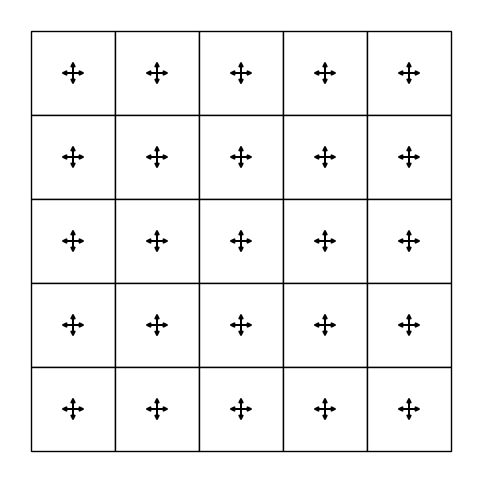

In [3]:
obs_size = env.observation_space.n # Which is grid_size**2
act_size = env.action_space.n
agent = agents.DeepREINFORCEAgentE(obs_size, act_size, time_horizon, 0.005)
print_gridworld_with_policy(agent=agent, env=env)

In [4]:
n_episodes = 101
n_traj = 5
discount_factor = 0.99
time_horizon = 25

learning_rate = 0.05
                         
env = gym.make("GridworldEnvGoalless-v0", time_horizon=time_horizon, prob=0)

print(env.observation_space.shape)
if __name__ == '__main__':

    ohe_matrix = np.eye(env.observation_space.n)
    obs_size = env.observation_space.n # Which is grid_size**2
    act_size = env.action_space.n
    
    list_entropies = []

    agent = agents.DeepREINFORCEAgentE(obs_size, act_size, time_horizon, learning_rate)

    avg_entropies = []
    for i in range(n_episodes):
        buffer = agents.Buffer()
        entropies = []
        for k in range(n_traj):
            # Reset the environment
            state, info = env.reset()
            done = False
            # Initialize the state visitation
            d_t = np.zeros(env.observation_space.n)
            episode = []
            while not done:
                # env.render()
                # Update state_visitation
                d_t[state] += 1
                # Get the one hot encoding for the state
                ohe_state = ohe_matrix[state]
                # Sample the action
                action = agent.get_action(ohe_state)
                # Make the step of the environment
                next_state, reward, done, info = env.step(action)
                # Save the step
                episode.append((ohe_state, action))
                # Update the current state
                state = next_state
            d_t /= time_horizon
            print("Episode:" + str(i) + " Trajectory:" + str(k))
            entropy = agent.compute_entropy(d_t)
            entropies.append(entropy)
            buffer.store(episode, entropy)
        avg_entropies.append(np.mean(entropies))
        obs_batch, act_batch, ent_batch = buffer.get_batch()

        agent.train(obs_batch, act_batch, ent_batch)

        #if i % 10 == 0:
        print('Ep:%d MnEnt:%.2f MxEnt:%.1f' % (i, np.mean(entropies), np.max(entropies)))
        print_gridworld_with_policy(agent, env)
        list_entropies.append(avg_entropies)
    list_entropies = np.transpose(np.array(list_entropies), (1,0))

    # Prepare values to print
    plot_args = {}
    entropies_means = np.mean(list_entropies, axis=1)
    entropies_stds = np.std(list_entropies, axis=1)
    plot_args['Learned Entropy'] = [entropies_means, entropies_stds]
    plot_graph(n_run=1, n_episodes=n_episodes, plot_args=plot_args, confidence=0.95, objective='Entropy', title="Test Entropy NN")

    env.close()

()
1/1 [==============================] - 0s 21ms/step


/home/duilio999/.pyenv/versions/3.10.12/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:219: DeprecationWarning: WARN: Core environment is written in old step API which returns one bool instead of two. It is recommended to rewrite the environment with new step API. 
  logger.deprecation(
/home/duilio999/.pyenv/versions/3.10.12/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:225: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(done, (bool, np.bool8)):


1/1 [==============================] - 0s 21ms/step
Episode:0 Trajectory:0
1/1 [==============================] - 0s 21ms/step
Episode:0 Trajectory:1
1/1 [==============================] - 0s 20ms/step
Episode:0 Trajectory:2
1/1 [==============================] - 0s 21ms/step
Episode:0 Trajectory:3
1/1 [==============================] - 0s 21ms/step
Episode:0 Trajectory:4
tf.Tensor(
[[0.25216874 0.24596778 0.24747616 0.25438735]
 [0.25423273 0.24606825 0.25151017 0.24818887]
 [0.246753   0.24832529 0.25045896 0.25446272]
 [0.25081074 0.24957061 0.24981478 0.24980387]
 [0.24768974 0.24625619 0.25189233 0.25416163]
 [0.24166994 0.24390113 0.25856102 0.25586805]
 [0.24579096 0.24898031 0.25145665 0.25377208]
 [0.25408253 0.24482894 0.25027052 0.25081798]
 [0.25408253 0.24482894 0.25027052 0.25081798]
 [0.25408253 0.24482894 0.25027052 0.25081798]
 [0.25408253 0.24482894 0.25027052 0.25081798]
 [0.24982852 0.24456246 0.25190407 0.25370494]
 [0.25408253 0.24482894 0.25027052 0.25081798]
 [0

ValueError: operands could not be broadcast together with shapes (125,4) (125,) 